## Title
Feature Engineering

### By:
Juan Gómez

### Date:
2024-05-16

### Description:

Clean and prepare message data from the Yelp dataset for the classification model. Remove duplicates, fix missing values, and keep useful columns only.


## Import  libraries

In [42]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline

## Load data

In [2]:
from pathlib import Path

pd.set_option("display.max_columns", None)

BASE_DIR = Path.cwd().resolve().parents[1]

In [3]:
df = pd.read_parquet(BASE_DIR / "data/02_intermediate/data_message_classifier_interm.parquet")

In [4]:
df.sample(5)

,review_id,stars,useful,funny,cool,text,date,review_count,useful_user,funny_user,cool_user,elite,fans,average_stars,address,city,state,stars_user,review_count_user,is_open,categories
867259,Rh70LeeuDKXuGmDsb7WJig,1,1,0,0,"Recently, my son and his boyfriend were in tow...",2018-10-29 04:46:45,5,3,0,0,,0,3.80,8110 Big Bend Blvd,Webster Groves,MO,4.0,47,True,"American (New), Sandwiches, Restaurants, Burge..."
473062,KC6sGDC4a_vRKDz9_iR2pQ,4,1,0,0,I visited Zeko's a few weeks ago and had my fi...,2019-12-08 04:40:34,-85,-15,3,-46,"2019,20,20,2021",3,4.57,3609 E Busch Blvd,Tampa,FL,4.5,89,True,"Restaurants, Falafel, Fast Food, Mediterranean..."
648531,IltWA-Mykhx4HLLeTxqSZQ,1,1,0,0,Should be zero stars!! Do not under any circu...,2019-06-06 13:37:13,14,12,3,2,,0,3.47,6744 Clayton Rd,Saint Louis,MO,4.0,5,True,"Health & Medical, Doctors"
563687,TjiA8x0kQtpwn-nq1akv4A,1,2,1,0,Food: I came in at lunchtime and grabbed the ...,2019-08-27 18:58:24,-93,23,54,47,2015,1,3.41,12322 Dorsett Rd,Maryland Heights,MO,3.5,126,True,"Restaurants, Indian, Pakistani, Seafood, Soup"
338653,lHqjzKMuBsAImZsdb-I2FQ,5,1,0,1,I tried this eyebrow store and found the lady ...,2020-07-02 20:09:11,115,62,5,9,,0,3.04,"6970 E 22nd St, Ste 110",Tucson,AZ,5.0,21,True,"Hair Removal, Threading Services, Beauty & Spa..."


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1499992 entries, 0 to 1499991
Data columns (total 21 columns):
 #   Column             Non-Null Count    Dtype         
---  ------             --------------    -----         
 0   review_id          1499992 non-null  string        
 1   stars              1499992 non-null  int64         
 2   useful             1499992 non-null  int8          
 3   funny              1499992 non-null  int8          
 4   cool               1499992 non-null  int8          
 5   text               1499992 non-null  string        
 6   date               1499992 non-null  datetime64[ns]
 7   review_count       1499992 non-null  int8          
 8   useful_user        1499992 non-null  int8          
 9   funny_user         1499992 non-null  int8          
 10  cool_user          1499992 non-null  int8          
 11  elite              1499992 non-null  category      
 12  fans               1499992 non-null  int8          
 13  average_stars      1499992 

In [6]:
df.shape

(1499992, 21)

# Data Preparation

### Type Columns

In [7]:
cols_categoric = df.select_dtypes(include=['category']).columns.tolist()

In [8]:
cols_num = df.select_dtypes(include=['int8', 'float64']).columns.tolist()

In [9]:
cols_boolean = df.select_dtypes(include=['bool']).columns.tolist()

In [10]:
cols_string = df.select_dtypes(include=['string']).columns.tolist()

In [11]:
col_date = df.select_dtypes(include=['datetime64[ns]']).columns.tolist()

### Remove duplicates

In [12]:
df_drop_duplicates = df.drop_duplicates(subset=["review_id"])

In [13]:
print(df_drop_duplicates.duplicated(subset=["review_id"]).sum())

0


### Missing values

In [14]:
df.isna().sum()

review_id              0
stars                  0
useful                 0
funny                  0
cool                   0
text                   0
date                   0
review_count           0
useful_user            0
funny_user             0
cool_user              0
elite                  0
fans                   0
average_stars          0
address                0
city                   0
state                  0
stars_user             0
review_count_user      0
is_open                0
categories           209
dtype: int64

### Handle outliers

In [15]:
for col in cols_num:
    q1 = df_drop_duplicates[col].quantile(0.25)
    q3 = df_drop_duplicates[col].quantile(0.75)
    iqr = q3 - q1
    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr
    outliers = df_drop_duplicates[(df_drop_duplicates[col] < lower) | (df_drop_duplicates[col] > upper)]
    print(f"{col}: {len(outliers)} outliers")

useful: 224934 outliers
funny: 367903 outliers
cool: 137473 outliers
review_count: 233174 outliers
useful_user: 251592 outliers
funny_user: 304153 outliers
cool_user: 324236 outliers
fans: 251584 outliers
average_stars: 105008 outliers
stars_user: 41591 outliers
review_count_user: 0 outliers


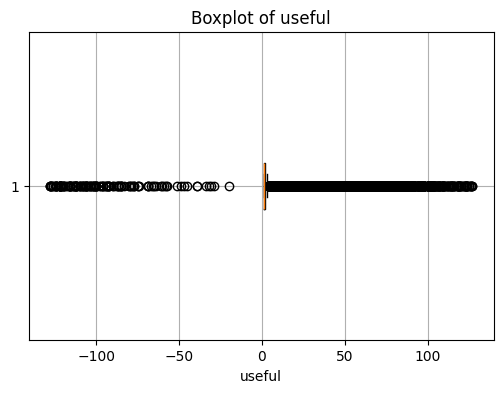

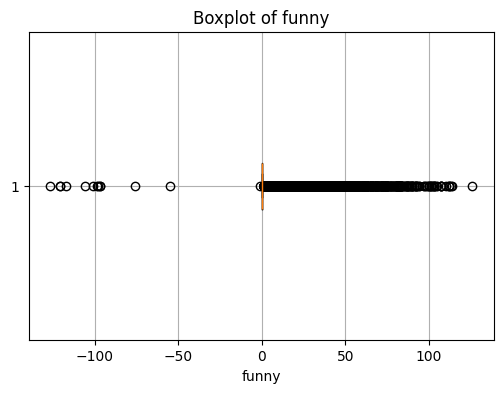

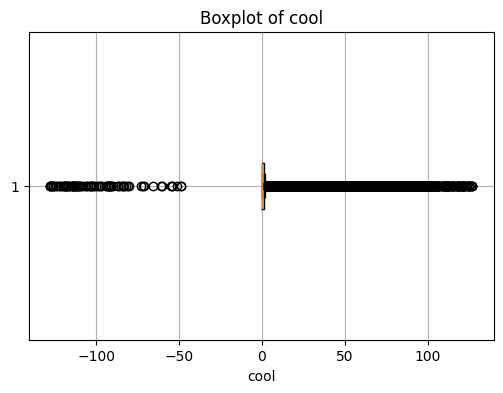

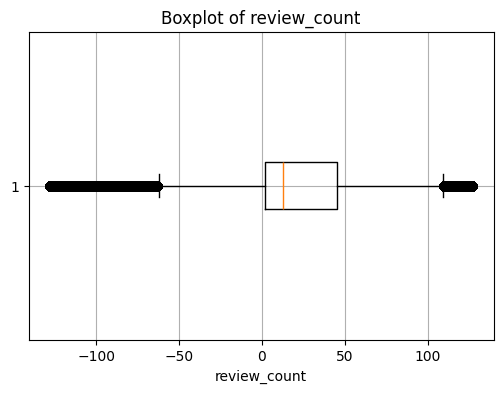

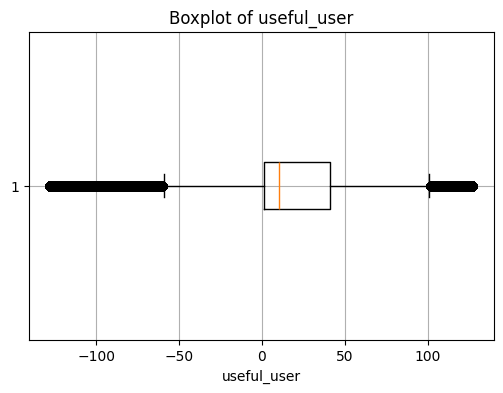

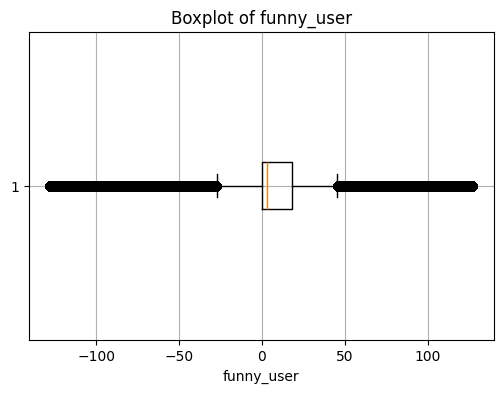

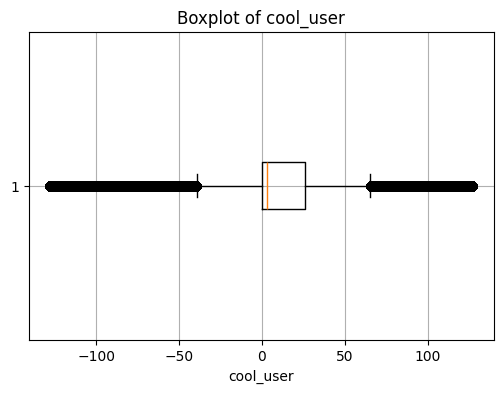

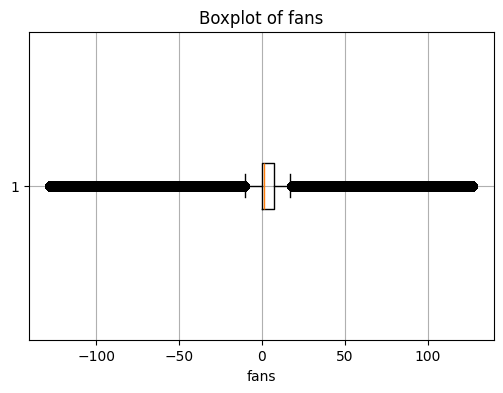

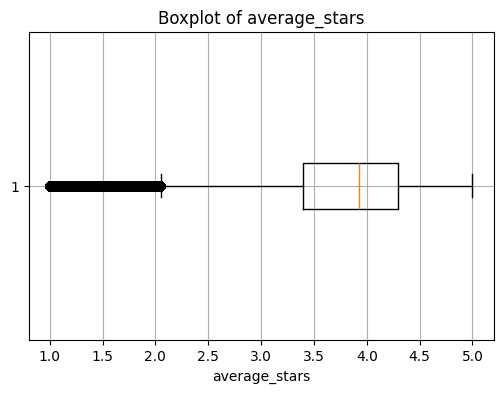

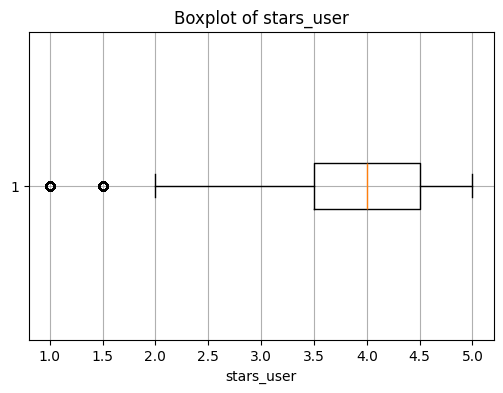

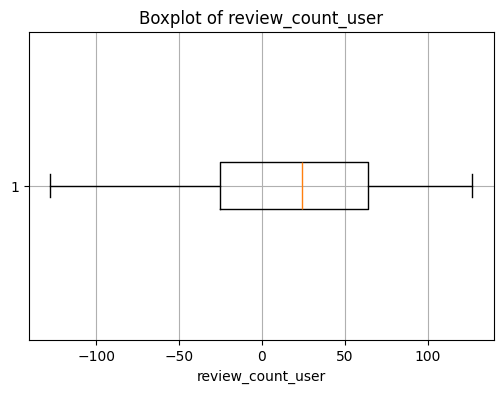

In [16]:
for col in cols_num:
    plt.figure(figsize=(6, 4))
    plt.boxplot(df_drop_duplicates[col].dropna(), vert=False)
    plt.title(f'Boxplot of {col}')
    plt.xlabel(col)
    plt.grid(True)
    plt.show()

### Drop unnecessary columns

In [17]:
for col in cols_num:
    mean = df_drop_duplicates[col].mean()
    std = df_drop_duplicates[col].std()
    cv = std / mean if mean != 0 else 0
    print(f"{col}: std = {std:.2f}, mean = {mean:.2f}, CV = {cv:.2f}")

useful: std = 3.95, mean = 2.44, CV = 1.62
funny: std = 2.05, mean = 0.53, CV = 3.85
cool: std = 3.38, mean = 1.08, CV = 3.14
review_count: std = 54.63, mean = 15.24, CV = 3.58
useful_user: std = 53.14, mean = 13.36, CV = 3.98
funny_user: std = 38.55, mean = 9.98, CV = 3.86
cool_user: std = 45.72, mean = 10.26, CV = 4.45
fans: std = 23.09, mean = 6.96, CV = 3.32
average_stars: std = 0.90, mean = 3.72, CV = 0.24
stars_user: std = 0.82, mean = 3.76, CV = 0.22
review_count_user: std = 66.42, mean = 15.66, CV = 4.24


In [18]:
for col in cols_categoric + cols_string:
    print(f"{col}: {df_drop_duplicates[col].nunique()} unique values")

elite: 838 unique values
city: 1299 unique values
state: 24 unique values
review_id: 1499992 unique values
text: 1498155 unique values
address: 103378 unique values
categories: 70431 unique values


In [19]:
df2 = df_drop_duplicates.drop(columns=["review_id"])

# Feature Engineering

### Categorical Variables

In [20]:
cols_categoric.append("stars")
df2[cols_categoric] = df2[cols_categoric].astype("category")

In [21]:
cols_categoric

['elite', 'city', 'state', 'stars']

#### Elite

In [22]:
def fix_elite_format(val):
    if pd.isna(val) or val == "None":
        return None

    years = {
        "20" + y if len(y) == 2 and y.isdigit() else y.strip()
        for y in val.split(",")
    }
    return ",".join(sorted(years))

In [23]:
df2["elite"] = df2["elite"].apply(fix_elite_format)

In [24]:
df2["elite_count"] = df2["elite"].fillna("").apply(
    lambda x: 0 if x in ["None", ""] else len(x.split(","))
)

In [25]:
df3 = df2.drop(columns=["elite"])

#### City

In [26]:
city_freq = df["city"].value_counts(normalize=True)
df3["city_freq"] = df3["city"].map(city_freq)

In [27]:
df4 = df3.drop(columns=["city"])

#### State

In [28]:
state_freq = df["state"].value_counts(normalize=True)
df4["state_freq"] = df4["state"].map(state_freq)

In [29]:
df5 = df4.drop(columns=["state"])

#### Stars

In [ ]:
def classify_sentiment(stars):
    if stars <= 2:
        return 0  # negative
    elif stars == 3:
        return 1  # neutral
    else:
        return 2  # positive

In [31]:
df5["target"] = df5["stars"].apply(classify_sentiment)

In [32]:
df6 = df5.drop(columns=["stars"])

In [34]:
df6["target"].value_counts()

target
2    942408
0    428805
1    128779
Name: count, dtype: int64

#### Pipeline

- EliteCountTransformer

In [38]:
class EliteCountTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()

        def fix_elite(val):
            if pd.isna(val) or val == "None":
                return ""
            years = {
                "20" + y if len(y) == 2 and y.isdigit() else y.strip()
                for y in val.split(",")
            }
            return ",".join(sorted(years))

        X["elite"] = X["elite"].apply(fix_elite)
        X["elite_count"] = X["elite"].apply(lambda x: 0 if x == "" else len(x.split(",")))
        X.drop(columns=["elite"], inplace=True)
        return X

- CityStateFreqTransformer

In [39]:
class CityStateFreqTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        self.city_freq = X["city"].value_counts(normalize=True)
        self.state_freq = X["state"].value_counts(normalize=True)
        return self

    def transform(self, X):
        X = X.copy()
        X["city_freq"] = X["city"].map(self.city_freq)
        X["state_freq"] = X["state"].map(self.state_freq)
        X.drop(columns=["city", "state"], inplace=True)
        return X

- TargetFromStarsTransformer

In [40]:
class TargetFromStarsTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()

        def classify(stars):
            if stars <= 2:
                return 0
            elif stars == 3:
                return 1
            else:
                return 2

        X["target"] = X["stars"].apply(classify)
        X.drop(columns=["stars"], inplace=True)
        return X

- Pipeline

In [43]:
categorical_pipe = Pipeline(
    steps=[
        ("elite_count", EliteCountTransformer()),
        ("freq_encode", CityStateFreqTransformer()),
        ("create_target", TargetFromStarsTransformer()),
    ]
)

### Numerical Variables

### Boolean Variables

### String Variables

### Data Variables